In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.functional as f 
from torch.autograd import Variable
torch.backends.cudnn.deterministic = True
import pandas as pd
import numpy as np
import torch.utils.data as data_utils
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random 
from matplotlib import pyplot as plt
from sklearn import decomposition
from sklearn import manifold
from scipy import stats
from itertools import cycle
import sys
import utilities as ut
from Network import Net
import Network as nn
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True


results = []
num_classes = 2

learning_rate = 0.001
samples = 3000

for epsilon in [0.2]:
    for batch_size in [256]:
        for hidden_size in [100]:
            for EPS1 in [0.005]:
                for n in [10000]:
                    for aux_loss_activated in [True]:
                        for opt in [2]:
                            for t in range(1):
                                train_dataset, test_dataset = ut.load_files(dataset=1)
                                input_size = train_dataset.shape[1]-1                                
                                if n < 50000:
                                    train_dataset = ut.down_sampling(train_dataset)
                                    train_dataset = train_dataset.sample(n)
                                    print(train_dataset)
                                else: 
                                    trainig_dataset_a = train_dataset[train_dataset.label=='ClassA']
                                    print('shape: ', trainig_dataset_a.shape[0])
                                    n2 = n - trainig_dataset_a.shape[0]
                                    print('clase no RR Lrae', n2)
                                    trainig_dataset_b = train_dataset[~(train_dataset.label=='ClassA')].sample(n2)
                                    train_dataset = pd.concat([trainig_dataset_a, trainig_dataset_b])
                                
                                train_dataset, test_dataset = ut.delete_outliers(train_dataset, test_dataset)

                                train_dataset = ut.sort_columns(train_dataset)
                                test_dataset = ut.sort_columns(test_dataset)
                                #... normalize ...
                                train_dataset, test_dataset = ut.normalize(train_dataset, test_dataset)
                                #print(train_dataset.columns)
                                test_dataset_pred = test_dataset.copy()
                                train_dataset_pred = train_dataset.copy()
                                try:
                                    data_prior = ut.generate_samples(samples, train_dataset, epsilon,  option = opt)

                                    train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.2, random_state=42)

                                    train_dataset_prior, val_dataset_prior = train_test_split(data_prior, test_size=0.2, random_state=42)
                                    print(train_dataset_prior.columns)


                                    _, _, train_target_prior, train_loader_prior = ut.get_tensors(train_dataset_prior, batch_size)
                                    _, _, val_target_prior, val_loader_prior     = ut.get_tensors(val_dataset_prior, batch_size)
                                    _, _, train_target, train_loader             = ut.get_tensors(train_dataset, batch_size)
                                    _, _, train_target_pred, train_loader_pred   = ut.get_tensors(train_dataset_pred, batch_size)
                                    _, _, val_target, val_loader                 = ut.get_tensors(val_dataset_prior, batch_size)
                                    _, _, test_target, test_loader               = ut.get_tensors(test_dataset, batch_size)
                                    _, _, test_target_pred, test_loader_pred     = ut.get_tensors(test_dataset_pred, batch_size)

                                    net = Net(input_size, hidden_size, hidden_size, num_classes)
                                    net.cuda()

                                    hist_val, hist_train = nn.train(net, train_loader, train_loader_prior, val_loader, test_loader,
                                    EPS1, learning_rate, input_size, aux_loss_activated=aux_loss_activated)

                                    acc_train, recall_train, f1_train = nn.get_results(net, train_loader, input_size)
                                    acc_test, recall_test, f1_test  = nn.get_results(net, test_loader, input_size)
                                    results.append([acc_train, acc_test,recall_train, recall_test, f1_train, f1_test, epsilon, batch_size, hidden_size, aux_loss_activated, EPS1, n, opt])
                                    #pd.DataFrame(results, columns=['acc_train', 'acc_test','recall_train', 'recall_test','f1_train', 'f1_test',
                                    # 'epsilon', 'batch_size', 'hidden_size',
                                    # 'aux_loss_activated', 'EPS1', 'n', 'opt']).to_csv('25-04-2022-results1D.csv')
                                    nn.get_roc_curve(net, test_loader, input_size, name= str(t)+"_", title="Regularization")
                                except Exception as error:
                                    print(error) 
                                    print(str(epsilon)+"-"+str(batch_size)+"-"+str(hidden_size)+"-"+str(aux_loss_activated)+"-"+str(EPS1))
                                    

/home/franciscoperez/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)
In /home/franciscoperez/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/franciscoperez/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/franciscoperez/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/franciscoperez/anacon

Freq1_harmonics_rel_phase_0
Freq2_harmonics_rel_phase_0
Freq3_harmonics_rel_phase_0
downsampling
28847
362654
done downsampling
        Amplitude  AndersonDarling  Autocor_length  Beyond1Std    CAR_mean  \
408027     0.0135         0.171236               2    0.330189   25.439073   
375271     0.3820         0.000000               1    0.395349   31.547271   
389707     0.8450         0.000000              12    0.401869    0.020022   
164826     0.2120         0.020923               1    0.330000  100.205777   
326806     0.0910         0.000000              26    0.374150    0.074815   
...           ...              ...             ...         ...         ...   
172801     0.2985         0.001336               1    0.310000   15.014133   
158152     0.3230         0.020765               1    0.319277   31.108072   
165728     0.3185         0.000001               1    0.387960   55.873805   
371704     0.2815         0.012085               1    0.373832    9.926920   
427410     0.2

/home/franciscoperez/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Epochs:  1000
Epoch:  0
training: epoch:  1  loss:  13.874267727136612 -- aux loss:  281.3954516351223
validating: epoch:  1  loss:  2.4256163835525513
Epoch:  1
training: epoch:  2  loss:  9.654902130365372 -- aux loss:  194.12608447670937
validating: epoch:  2  loss:  1.8253071308135986
Epoch:  2
training: epoch:  3  loss:  8.884406059980392 -- aux loss:  164.31752794981003
validating: epoch:  3  loss:  1.6738594472408295
Epoch:  3
training: epoch:  4  loss:  8.580181121826172 -- aux loss:  156.16178131103516
validating: epoch:  4  loss:  1.6230806410312653
Epoch:  4
training: epoch:  5  loss:  8.407962620258331 -- aux loss:  152.9868836402893
validating: epoch:  5  loss:  1.6000154912471771
Epoch:  5
training: epoch:  6  loss:  8.32447761297226 -- aux loss:  151.421773314476
validating: epoch:  6  loss:  1.5878401100635529
Epoch:  6
training: epoch:  7  loss:  8.274911493062973 -- aux loss:  150.5534763634205
validating: epoch:  7  loss:  1.5807642340660095
Epoch:  7
training: epoch

training: epoch:  41  loss:  8.021521717309952 -- aux loss:  148.89707550406456
validating: epoch:  41  loss:  1.5663096904754639
Epoch:  41
training: epoch:  42  loss:  8.019798964262009 -- aux loss:  148.89706459641457
validating: epoch:  42  loss:  1.566309541463852
Epoch:  42
training: epoch:  43  loss:  8.018506318330765 -- aux loss:  148.89705711603165
validating: epoch:  43  loss:  1.56630939245224
Epoch:  43
training: epoch:  44  loss:  8.017127513885498 -- aux loss:  148.89705404639244
validating: epoch:  44  loss:  1.56630939245224
Epoch:  44
training: epoch:  45  loss:  8.015860676765442 -- aux loss:  148.89705368876457
validating: epoch:  45  loss:  1.56630939245224
Epoch:  45
training: epoch:  46  loss:  8.014729112386703 -- aux loss:  148.897021651268
validating: epoch:  46  loss:  1.5663085877895355
Epoch:  46
training: epoch:  47  loss:  8.013671606779099 -- aux loss:  148.8969695866108
validating: epoch:  47  loss:  1.5663082897663116
Epoch:  47
training: epoch:  48  l

training: epoch:  81  loss:  7.99433234333992 -- aux loss:  148.89693036675453
validating: epoch:  81  loss:  1.566308081150055
Epoch:  81
training: epoch:  82  loss:  7.993910580873489 -- aux loss:  148.89693036675453
validating: epoch:  82  loss:  1.566308081150055
Epoch:  82
training: epoch:  83  loss:  7.993674665689468 -- aux loss:  148.89693036675453
validating: epoch:  83  loss:  1.566308081150055
Epoch:  83
training: epoch:  84  loss:  7.9934713542461395 -- aux loss:  148.89693036675453
validating: epoch:  84  loss:  1.566308081150055
Epoch:  84
training: epoch:  85  loss:  7.993265509605408 -- aux loss:  148.89693036675453
validating: epoch:  85  loss:  1.566308081150055
Epoch:  85
training: epoch:  86  loss:  7.993028283119202 -- aux loss:  148.89693036675453
validating: epoch:  86  loss:  1.566308081150055
Epoch:  86
training: epoch:  87  loss:  7.9927137196063995 -- aux loss:  148.89693036675453
validating: epoch:  87  loss:  1.566308081150055
Epoch:  87
training: epoch:  8

training: epoch:  121  loss:  7.978840678930283 -- aux loss:  148.89693036675453
validating: epoch:  121  loss:  1.566308081150055
Epoch:  121
training: epoch:  122  loss:  7.978770673274994 -- aux loss:  148.89693036675453
validating: epoch:  122  loss:  1.566308081150055
Epoch:  122
training: epoch:  123  loss:  7.978707104921341 -- aux loss:  148.89693036675453
validating: epoch:  123  loss:  1.566308081150055
Epoch:  123
training: epoch:  124  loss:  7.978648990392685 -- aux loss:  148.89693036675453
validating: epoch:  124  loss:  1.566308081150055
Epoch:  124
training: epoch:  125  loss:  7.978595197200775 -- aux loss:  148.89693036675453
validating: epoch:  125  loss:  1.566308081150055
Epoch:  125
training: epoch:  126  loss:  7.97854483127594 -- aux loss:  148.89693036675453
validating: epoch:  126  loss:  1.566308081150055
Epoch:  126
training: epoch:  127  loss:  7.978498131036758 -- aux loss:  148.89693036675453
validating: epoch:  127  loss:  1.566308081150055
Epoch:  127


training: epoch:  161  loss:  7.977546244859695 -- aux loss:  148.89693036675453
validating: epoch:  161  loss:  1.566308081150055
Epoch:  161
training: epoch:  162  loss:  7.977107644081116 -- aux loss:  148.8969304561615
validating: epoch:  162  loss:  1.5663081109523773
Epoch:  162
training: epoch:  163  loss:  7.975636541843414 -- aux loss:  148.89693036675453
validating: epoch:  163  loss:  1.566308081150055
Epoch:  163
training: epoch:  164  loss:  7.975467145442963 -- aux loss:  148.89693036675453
validating: epoch:  164  loss:  1.566308081150055
Epoch:  164
training: epoch:  165  loss:  7.975408762693405 -- aux loss:  148.89693036675453
validating: epoch:  165  loss:  1.566308081150055
Epoch:  165
training: epoch:  166  loss:  7.975377559661865 -- aux loss:  148.89693036675453
validating: epoch:  166  loss:  1.566308081150055
Epoch:  166
training: epoch:  167  loss:  7.975343346595764 -- aux loss:  148.89693036675453
validating: epoch:  167  loss:  1.566308081150055
Epoch:  167

training: epoch:  201  loss:  7.973505288362503 -- aux loss:  148.89693036675453
validating: epoch:  201  loss:  1.566308081150055
Epoch:  201
training: epoch:  202  loss:  7.973486453294754 -- aux loss:  148.89693036675453
validating: epoch:  202  loss:  1.566308081150055
Epoch:  202
training: epoch:  203  loss:  7.97347155213356 -- aux loss:  148.89693036675453
validating: epoch:  203  loss:  1.566308081150055
Epoch:  203
training: epoch:  204  loss:  7.973458260297775 -- aux loss:  148.89693036675453
validating: epoch:  204  loss:  1.566308081150055
Epoch:  204
training: epoch:  205  loss:  7.973446309566498 -- aux loss:  148.89693036675453
validating: epoch:  205  loss:  1.566308081150055
Epoch:  205
training: epoch:  206  loss:  7.973435163497925 -- aux loss:  148.89693036675453
validating: epoch:  206  loss:  1.566308081150055
Epoch:  206
training: epoch:  207  loss:  7.973424941301346 -- aux loss:  148.89693036675453
validating: epoch:  207  loss:  1.566308081150055
Epoch:  207


training: epoch:  241  loss:  7.973244220018387 -- aux loss:  148.89693036675453
validating: epoch:  241  loss:  1.566308081150055
Epoch:  241
training: epoch:  242  loss:  7.973241031169891 -- aux loss:  148.89693036675453
validating: epoch:  242  loss:  1.566308081150055
Epoch:  242
training: epoch:  243  loss:  7.973237931728363 -- aux loss:  148.89693036675453
validating: epoch:  243  loss:  1.566308081150055
Epoch:  243
training: epoch:  244  loss:  7.973234593868256 -- aux loss:  148.89693036675453
validating: epoch:  244  loss:  1.566308081150055
Epoch:  244
training: epoch:  245  loss:  7.9732314348220825 -- aux loss:  148.89693036675453
validating: epoch:  245  loss:  1.566308081150055
Epoch:  245
training: epoch:  246  loss:  7.973228424787521 -- aux loss:  148.89693036675453
validating: epoch:  246  loss:  1.566308081150055
Epoch:  246
training: epoch:  247  loss:  7.97322541475296 -- aux loss:  148.89693036675453
validating: epoch:  247  loss:  1.566308081150055
Epoch:  247

training: epoch:  281  loss:  7.973131954669952 -- aux loss:  148.89693036675453
validating: epoch:  281  loss:  1.566308081150055
Epoch:  281
training: epoch:  282  loss:  7.973111569881439 -- aux loss:  148.89693036675453
validating: epoch:  282  loss:  1.566308081150055
Epoch:  282
training: epoch:  283  loss:  7.973397761583328 -- aux loss:  148.89693036675453
validating: epoch:  283  loss:  1.566308081150055
Epoch:  283
training: epoch:  284  loss:  7.975974857807159 -- aux loss:  148.89693036675453
validating: epoch:  284  loss:  1.566308081150055
Epoch:  284
training: epoch:  285  loss:  7.976421743631363 -- aux loss:  148.89693036675453
validating: epoch:  285  loss:  1.566308081150055
Epoch:  285
training: epoch:  286  loss:  7.973144382238388 -- aux loss:  148.89693036675453
validating: epoch:  286  loss:  1.566308081150055
Epoch:  286
training: epoch:  287  loss:  7.969748318195343 -- aux loss:  148.89693036675453
validating: epoch:  287  loss:  1.566308081150055
Epoch:  287

training: epoch:  321  loss:  7.955169349908829 -- aux loss:  148.89693036675453
validating: epoch:  321  loss:  1.566308081150055
Epoch:  321
training: epoch:  322  loss:  7.9550802409648895 -- aux loss:  148.89693036675453
validating: epoch:  322  loss:  1.566308081150055
Epoch:  322
training: epoch:  323  loss:  7.954476416110992 -- aux loss:  148.89693036675453
validating: epoch:  323  loss:  1.566308081150055
Epoch:  323
training: epoch:  324  loss:  7.954202264547348 -- aux loss:  148.89693036675453
validating: epoch:  324  loss:  1.566308081150055
Epoch:  324
training: epoch:  325  loss:  7.954108476638794 -- aux loss:  148.89693036675453
validating: epoch:  325  loss:  1.566308081150055
Epoch:  325
training: epoch:  326  loss:  7.954072654247284 -- aux loss:  148.89693036675453
validating: epoch:  326  loss:  1.566308081150055
Epoch:  326
training: epoch:  327  loss:  7.954043030738831 -- aux loss:  148.89693036675453
validating: epoch:  327  loss:  1.566308081150055
Epoch:  32

training: epoch:  361  loss:  7.938473433256149 -- aux loss:  148.89693036675453
validating: epoch:  361  loss:  1.566308081150055
Epoch:  361
training: epoch:  362  loss:  7.937542676925659 -- aux loss:  148.89693036675453
validating: epoch:  362  loss:  1.566308081150055
Epoch:  362
training: epoch:  363  loss:  7.935703933238983 -- aux loss:  148.89693036675453
validating: epoch:  363  loss:  1.566308081150055
Epoch:  363
training: epoch:  364  loss:  7.9343737959861755 -- aux loss:  148.89693036675453
validating: epoch:  364  loss:  1.566308081150055
Epoch:  364
training: epoch:  365  loss:  7.933630049228668 -- aux loss:  148.89693036675453
validating: epoch:  365  loss:  1.566308081150055
Epoch:  365
training: epoch:  366  loss:  7.9323447942733765 -- aux loss:  148.89693036675453
validating: epoch:  366  loss:  1.566308081150055
Epoch:  366
training: epoch:  367  loss:  7.931633770465851 -- aux loss:  148.89693036675453
validating: epoch:  367  loss:  1.566308081150055
Epoch:  3

training: epoch:  401  loss:  7.931113094091415 -- aux loss:  148.89693036675453
validating: epoch:  401  loss:  1.566308081150055
Epoch:  401
training: epoch:  402  loss:  7.930485934019089 -- aux loss:  148.89693036675453
validating: epoch:  402  loss:  1.566308081150055
Epoch:  402
training: epoch:  403  loss:  7.926860600709915 -- aux loss:  148.89693036675453
validating: epoch:  403  loss:  1.566308081150055
Epoch:  403
training: epoch:  404  loss:  7.926384747028351 -- aux loss:  148.89693036675453
validating: epoch:  404  loss:  1.566308081150055
Epoch:  404
training: epoch:  405  loss:  7.923056930303574 -- aux loss:  148.89693036675453
validating: epoch:  405  loss:  1.566308081150055
Epoch:  405
training: epoch:  406  loss:  7.922846227884293 -- aux loss:  148.89693036675453
validating: epoch:  406  loss:  1.566308081150055
Epoch:  406
training: epoch:  407  loss:  7.922788083553314 -- aux loss:  148.89693036675453
validating: epoch:  407  loss:  1.566308081150055
Epoch:  407

training: epoch:  441  loss:  7.922452509403229 -- aux loss:  148.89693036675453
validating: epoch:  441  loss:  1.566308081150055
Epoch:  441
training: epoch:  442  loss:  7.922449350357056 -- aux loss:  148.89693036675453
validating: epoch:  442  loss:  1.566308081150055
Epoch:  442
training: epoch:  443  loss:  7.9224458038806915 -- aux loss:  148.89693036675453
validating: epoch:  443  loss:  1.566308081150055
Epoch:  443
training: epoch:  444  loss:  7.922442525625229 -- aux loss:  148.89693036675453
validating: epoch:  444  loss:  1.566308081150055
Epoch:  444
training: epoch:  445  loss:  7.92243954539299 -- aux loss:  148.89693036675453
validating: epoch:  445  loss:  1.566308081150055
Epoch:  445
training: epoch:  446  loss:  7.922436505556107 -- aux loss:  148.89693036675453
validating: epoch:  446  loss:  1.566308081150055
Epoch:  446
training: epoch:  447  loss:  7.92243355512619 -- aux loss:  148.89693036675453
validating: epoch:  447  loss:  1.566308081150055
Epoch:  447


recall
tensor(0.9542)
precision
tensor(0.6746)
f1_score
tensor(0.7904)
Accuracy of the network on test objects: 67 %
67.457985
sum mask2 - L1:  tensor(5737, device='cuda:0')
sum mask2 - L2:  tensor(9508, device='cuda:0')
sum mask2 - L3:  tensor(192, device='cuda:0')
sum mask1 - L1 (aux):  tensor(263, device='cuda:0')
sum mask1 - L2 (aux):  tensor(492, device='cuda:0')
sum mask1 - L3 (aux):  tensor(8, device='cuda:0')
Epoch:  480
training: epoch:  481  loss:  7.9379225969314575 -- aux loss:  148.89693036675453
validating: epoch:  481  loss:  1.566308081150055
Epoch:  481
training: epoch:  482  loss:  7.9532957673072815 -- aux loss:  148.89693036675453
validating: epoch:  482  loss:  1.566308081150055
Epoch:  482
training: epoch:  483  loss:  7.918603777885437 -- aux loss:  148.89693036675453
validating: epoch:  483  loss:  1.566308081150055
Epoch:  483
training: epoch:  484  loss:  7.917801946401596 -- aux loss:  148.89693036675453
validating: epoch:  484  loss:  1.566308081150055
Epoch

training: epoch:  520  loss:  7.902865320444107 -- aux loss:  148.89693036675453
validating: epoch:  520  loss:  1.566308081150055
The current loss: 1.566308081150055
the_last_loss: 1.566308081150055
trigger times: 0
recall
tensor(0.9992)
precision
tensor(0.9964)
f1_score
tensor(0.9978)
Accuracy of the network on test objects: 99 %
99.63707
recall
tensor(1.)
precision
tensor(1.)
f1_score
tensor(1.)
Accuracy of the network on test objects: 100 %
100.0
recall
tensor(0.9488)
precision
tensor(0.7047)
f1_score
tensor(0.8087)
Accuracy of the network on test objects: 70 %
70.46731
sum mask2 - L1:  tensor(5737, device='cuda:0')
sum mask2 - L2:  tensor(9508, device='cuda:0')
sum mask2 - L3:  tensor(192, device='cuda:0')
sum mask1 - L1 (aux):  tensor(263, device='cuda:0')
sum mask1 - L2 (aux):  tensor(492, device='cuda:0')
sum mask1 - L3 (aux):  tensor(8, device='cuda:0')
Epoch:  520
training: epoch:  521  loss:  7.900682300329208 -- aux loss:  148.89693036675453
validating: epoch:  521  loss:  

training: epoch:  557  loss:  7.899041920900345 -- aux loss:  148.89693036675453
validating: epoch:  557  loss:  1.566308081150055
Epoch:  557
training: epoch:  558  loss:  7.899038791656494 -- aux loss:  148.89693036675453
validating: epoch:  558  loss:  1.566308081150055
Epoch:  558
training: epoch:  559  loss:  7.899035423994064 -- aux loss:  148.89693036675453
validating: epoch:  559  loss:  1.566308081150055
Epoch:  559
training: epoch:  560  loss:  7.8990322053432465 -- aux loss:  148.89693036675453
validating: epoch:  560  loss:  1.566308081150055
The current loss: 1.566308081150055
the_last_loss: 1.566308081150055
trigger times: 0
recall
tensor(0.9992)
precision
tensor(0.9964)
f1_score
tensor(0.9978)
Accuracy of the network on test objects: 99 %
99.63707
recall
tensor(1.)
precision
tensor(1.)
f1_score
tensor(1.)
Accuracy of the network on test objects: 100 %
100.0
recall
tensor(0.9490)
precision
tensor(0.7059)
f1_score
tensor(0.8096)
Accuracy of the network on test objects: 70 

training: epoch:  594  loss:  7.8989497423172 -- aux loss:  148.89693036675453
validating: epoch:  594  loss:  1.566308081150055
Epoch:  594
training: epoch:  595  loss:  7.8989477455616 -- aux loss:  148.89693036675453
validating: epoch:  595  loss:  1.566308081150055
Epoch:  595
training: epoch:  596  loss:  7.898946046829224 -- aux loss:  148.89693036675453
validating: epoch:  596  loss:  1.566308081150055
Epoch:  596
training: epoch:  597  loss:  7.898944646120071 -- aux loss:  148.89693036675453
validating: epoch:  597  loss:  1.566308081150055
Epoch:  597
training: epoch:  598  loss:  7.898942679166794 -- aux loss:  148.89693036675453
validating: epoch:  598  loss:  1.566308081150055
Epoch:  598
training: epoch:  599  loss:  7.89894112944603 -- aux loss:  148.89693036675453
validating: epoch:  599  loss:  1.566308081150055
Epoch:  599
training: epoch:  600  loss:  7.898939281702042 -- aux loss:  148.89693036675453
validating: epoch:  600  loss:  1.566308081150055
The current loss

training: epoch:  631  loss:  7.8988978266716 -- aux loss:  148.89693036675453
validating: epoch:  631  loss:  1.566308081150055
Epoch:  631
training: epoch:  632  loss:  7.89889669418335 -- aux loss:  148.89693036675453
validating: epoch:  632  loss:  1.566308081150055
Epoch:  632
training: epoch:  633  loss:  7.898895710706711 -- aux loss:  148.89693036675453
validating: epoch:  633  loss:  1.566308081150055
Epoch:  633
training: epoch:  634  loss:  7.898894757032394 -- aux loss:  148.89693036675453
validating: epoch:  634  loss:  1.566308081150055
Epoch:  634
training: epoch:  635  loss:  7.898893594741821 -- aux loss:  148.89693036675453
validating: epoch:  635  loss:  1.566308081150055
Epoch:  635
training: epoch:  636  loss:  7.898892670869827 -- aux loss:  148.89693036675453
validating: epoch:  636  loss:  1.566308081150055
Epoch:  636
training: epoch:  637  loss:  7.898891717195511 -- aux loss:  148.89693036675453
validating: epoch:  637  loss:  1.566308081150055
Epoch:  637
tr

training: epoch:  671  loss:  7.898865431547165 -- aux loss:  148.89693036675453
validating: epoch:  671  loss:  1.566308081150055
Epoch:  671
training: epoch:  672  loss:  7.898864984512329 -- aux loss:  148.89693036675453
validating: epoch:  672  loss:  1.566308081150055
Epoch:  672
training: epoch:  673  loss:  7.898864418268204 -- aux loss:  148.89693036675453
validating: epoch:  673  loss:  1.566308081150055
Epoch:  673
training: epoch:  674  loss:  7.898863762617111 -- aux loss:  148.89693036675453
validating: epoch:  674  loss:  1.566308081150055
Epoch:  674
training: epoch:  675  loss:  7.8988631665706635 -- aux loss:  148.89693036675453
validating: epoch:  675  loss:  1.566308081150055
Epoch:  675
training: epoch:  676  loss:  7.898862659931183 -- aux loss:  148.89693036675453
validating: epoch:  676  loss:  1.566308081150055
Epoch:  676
training: epoch:  677  loss:  7.898862153291702 -- aux loss:  148.89693036675453
validating: epoch:  677  loss:  1.566308081150055
Epoch:  67

training: epoch:  711  loss:  7.89505010843277 -- aux loss:  148.89693036675453
validating: epoch:  711  loss:  1.566308081150055
Epoch:  711
training: epoch:  712  loss:  7.895045042037964 -- aux loss:  148.89693036675453
validating: epoch:  712  loss:  1.566308081150055
Epoch:  712
training: epoch:  713  loss:  7.895040541887283 -- aux loss:  148.89693036675453
validating: epoch:  713  loss:  1.566308081150055
Epoch:  713
training: epoch:  714  loss:  7.895036548376083 -- aux loss:  148.89693036675453
validating: epoch:  714  loss:  1.566308081150055
Epoch:  714
training: epoch:  715  loss:  7.895033091306686 -- aux loss:  148.89693036675453
validating: epoch:  715  loss:  1.566308081150055
Epoch:  715
training: epoch:  716  loss:  7.8950298726558685 -- aux loss:  148.89693036675453
validating: epoch:  716  loss:  1.566308081150055
Epoch:  716
training: epoch:  717  loss:  7.8950269520282745 -- aux loss:  148.89693036675453
validating: epoch:  717  loss:  1.566308081150055
Epoch:  71

training: epoch:  751  loss:  7.894981324672699 -- aux loss:  148.89693036675453
validating: epoch:  751  loss:  1.566308081150055
Epoch:  751
training: epoch:  752  loss:  7.894980490207672 -- aux loss:  148.89693036675453
validating: epoch:  752  loss:  1.566308081150055
Epoch:  752
training: epoch:  753  loss:  7.894979745149612 -- aux loss:  148.89693036675453
validating: epoch:  753  loss:  1.566308081150055
Epoch:  753
training: epoch:  754  loss:  7.8949790596961975 -- aux loss:  148.89693036675453
validating: epoch:  754  loss:  1.566308081150055
Epoch:  754
training: epoch:  755  loss:  7.894978433847427 -- aux loss:  148.89693036675453
validating: epoch:  755  loss:  1.566308081150055
Epoch:  755
training: epoch:  756  loss:  7.89497771859169 -- aux loss:  148.89693036675453
validating: epoch:  756  loss:  1.566308081150055
Epoch:  756
training: epoch:  757  loss:  7.89497709274292 -- aux loss:  148.89693036675453
validating: epoch:  757  loss:  1.566308081150055
Epoch:  757


training: epoch:  791  loss:  7.894960314035416 -- aux loss:  148.89693036675453
validating: epoch:  791  loss:  1.566308081150055
Epoch:  791
training: epoch:  792  loss:  7.8949600756168365 -- aux loss:  148.89693036675453
validating: epoch:  792  loss:  1.566308081150055
Epoch:  792
training: epoch:  793  loss:  7.894959717988968 -- aux loss:  148.89693036675453
validating: epoch:  793  loss:  1.566308081150055
Epoch:  793
training: epoch:  794  loss:  7.89495924115181 -- aux loss:  148.89693036675453
validating: epoch:  794  loss:  1.566308081150055
Epoch:  794
training: epoch:  795  loss:  7.894958913326263 -- aux loss:  148.89693036675453
validating: epoch:  795  loss:  1.566308081150055
Epoch:  795
training: epoch:  796  loss:  7.89495849609375 -- aux loss:  148.89693036675453
validating: epoch:  796  loss:  1.566308081150055
Epoch:  796
training: epoch:  797  loss:  7.894958198070526 -- aux loss:  148.89693036675453
validating: epoch:  797  loss:  1.566308081150055
Epoch:  797


training: epoch:  831  loss:  7.8949481546878815 -- aux loss:  148.89693036675453
validating: epoch:  831  loss:  1.566308081150055
Epoch:  831
training: epoch:  832  loss:  7.89494788646698 -- aux loss:  148.89693036675453
validating: epoch:  832  loss:  1.566308081150055
Epoch:  832
training: epoch:  833  loss:  7.894947648048401 -- aux loss:  148.89693036675453
validating: epoch:  833  loss:  1.566308081150055
Epoch:  833
training: epoch:  834  loss:  7.894947350025177 -- aux loss:  148.89693036675453
validating: epoch:  834  loss:  1.566308081150055
Epoch:  834
training: epoch:  835  loss:  7.894947201013565 -- aux loss:  148.89693036675453
validating: epoch:  835  loss:  1.566308081150055
Epoch:  835
training: epoch:  836  loss:  7.894946992397308 -- aux loss:  148.89693036675453
validating: epoch:  836  loss:  1.566308081150055
Epoch:  836
training: epoch:  837  loss:  7.894946783781052 -- aux loss:  148.89693036675453
validating: epoch:  837  loss:  1.566308081150055
Epoch:  837

training: epoch:  871  loss:  7.894939988851547 -- aux loss:  148.89693036675453
validating: epoch:  871  loss:  1.566308081150055
Epoch:  871
training: epoch:  872  loss:  7.894939720630646 -- aux loss:  148.89693036675453
validating: epoch:  872  loss:  1.566308081150055
Epoch:  872
training: epoch:  873  loss:  7.894939571619034 -- aux loss:  148.89693036675453
validating: epoch:  873  loss:  1.566308081150055
Epoch:  873
training: epoch:  874  loss:  7.894939452409744 -- aux loss:  148.89693036675453
validating: epoch:  874  loss:  1.566308081150055
Epoch:  874
training: epoch:  875  loss:  7.89493915438652 -- aux loss:  148.89693036675453
validating: epoch:  875  loss:  1.566308081150055
Epoch:  875
training: epoch:  876  loss:  7.894938886165619 -- aux loss:  148.89693036675453
validating: epoch:  876  loss:  1.566308081150055
Epoch:  876
training: epoch:  877  loss:  7.894938796758652 -- aux loss:  148.89693036675453
validating: epoch:  877  loss:  1.566308081150055
Epoch:  877


training: epoch:  911  loss:  7.89493402838707 -- aux loss:  148.89693036675453
validating: epoch:  911  loss:  1.566308081150055
Epoch:  911
training: epoch:  912  loss:  7.89493390917778 -- aux loss:  148.89693036675453
validating: epoch:  912  loss:  1.566308081150055
Epoch:  912
training: epoch:  913  loss:  7.894933789968491 -- aux loss:  148.89693036675453
validating: epoch:  913  loss:  1.566308081150055
Epoch:  913
training: epoch:  914  loss:  7.894933640956879 -- aux loss:  148.89693036675453
validating: epoch:  914  loss:  1.566308081150055
Epoch:  914
training: epoch:  915  loss:  7.894933581352234 -- aux loss:  148.89693036675453
validating: epoch:  915  loss:  1.566308081150055
Epoch:  915
training: epoch:  916  loss:  7.894933432340622 -- aux loss:  148.89693036675453
validating: epoch:  916  loss:  1.566308081150055
Epoch:  916
training: epoch:  917  loss:  7.894933342933655 -- aux loss:  148.89693036675453
validating: epoch:  917  loss:  1.566308081150055
Epoch:  917
t

training: epoch:  951  loss:  7.894930303096771 -- aux loss:  148.89693036675453
validating: epoch:  951  loss:  1.566308081150055
Epoch:  951
training: epoch:  952  loss:  7.8949302434921265 -- aux loss:  148.89693036675453
validating: epoch:  952  loss:  1.566308081150055
Epoch:  952
training: epoch:  953  loss:  7.894930154085159 -- aux loss:  148.89693036675453
validating: epoch:  953  loss:  1.566308081150055
Epoch:  953
training: epoch:  954  loss:  7.894930124282837 -- aux loss:  148.89693036675453
validating: epoch:  954  loss:  1.566308081150055
Epoch:  954
training: epoch:  955  loss:  7.894930064678192 -- aux loss:  148.89693036675453
validating: epoch:  955  loss:  1.566308081150055
Epoch:  955
training: epoch:  956  loss:  7.894929975271225 -- aux loss:  148.89693036675453
validating: epoch:  956  loss:  1.566308081150055
Epoch:  956
training: epoch:  957  loss:  7.894929975271225 -- aux loss:  148.89693036675453
validating: epoch:  957  loss:  1.566308081150055
Epoch:  95

training: epoch:  991  loss:  7.894927740097046 -- aux loss:  148.89693036675453
validating: epoch:  991  loss:  1.566308081150055
Epoch:  991
training: epoch:  992  loss:  7.894927680492401 -- aux loss:  148.89693036675453
validating: epoch:  992  loss:  1.566308081150055
Epoch:  992
training: epoch:  993  loss:  7.894927650690079 -- aux loss:  148.89693036675453
validating: epoch:  993  loss:  1.566308081150055
Epoch:  993
training: epoch:  994  loss:  7.894927620887756 -- aux loss:  148.89693036675453
validating: epoch:  994  loss:  1.566308081150055
Epoch:  994
training: epoch:  995  loss:  7.894927591085434 -- aux loss:  148.89693036675453
validating: epoch:  995  loss:  1.566308081150055
Epoch:  995
training: epoch:  996  loss:  7.894927561283112 -- aux loss:  148.89693036675453
validating: epoch:  996  loss:  1.566308081150055
Epoch:  996
training: epoch:  997  loss:  7.894927531480789 -- aux loss:  148.89693036675453
validating: epoch:  997  loss:  1.566308081150055
Epoch:  997

<Figure size 640x480 with 1 Axes>

1.0


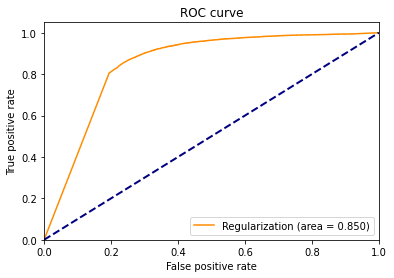

In [2]:
nn.get_roc_curve(net, test_loader, input_size, title="Regularization")

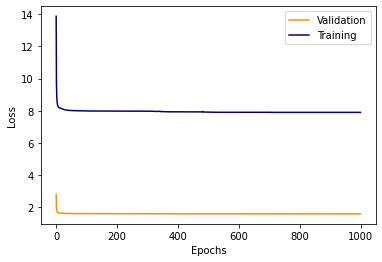

In [3]:
ut.plot_training(hist_val, hist_train)

In [4]:
nn.get_results(net, train_loader, input_size)
nn.get_results(net, test_loader, input_size)

recall
tensor(0.9992)
precision
tensor(0.9966)
f1_score
tensor(0.9979)
Accuracy of the network on test objects: 99 %
99.664894
recall
tensor(0.9522)
precision
tensor(0.7073)
f1_score
tensor(0.8117)
Accuracy of the network on test objects: 70 %
70.73352


(array(70.73352, dtype=float32),
 array(0.9522068, dtype=float32),
 array(0.8117051, dtype=float32))

In [5]:
torch.save(net.state_dict(), 'model.pkl')

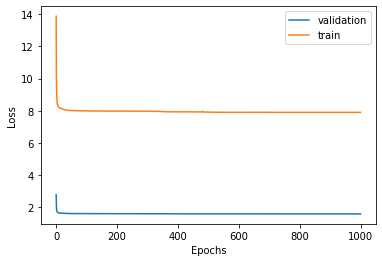

In [6]:
plt.plot(hist_val, label ='validation')
plt.plot(hist_train, label ='train')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.savefig('images/'+str(samples)+'_'+str(epsilon)+'_'+str(n)+"_"+str(hidden_size)+"_Loss_Training.png")
plt.show()

In [7]:
#csv_file = open("size_MLP_noise.csv", "a")
#csv_file.write(str(np.asarray(acc_testing))+","+str(np.asarray(acc_training))+","+str(samples)+","+str(epsilon)+","+str(n)+","+str(hidden_size)+"\n")
#csv_file.close()

In [8]:
outputs, intermediates, intermediates2, labels = ut.get_representations(net, train_loader, device)
outputs_test, intermediates_test, intermediates2_test, labels_test = ut.get_representations(net, test_loader, device)

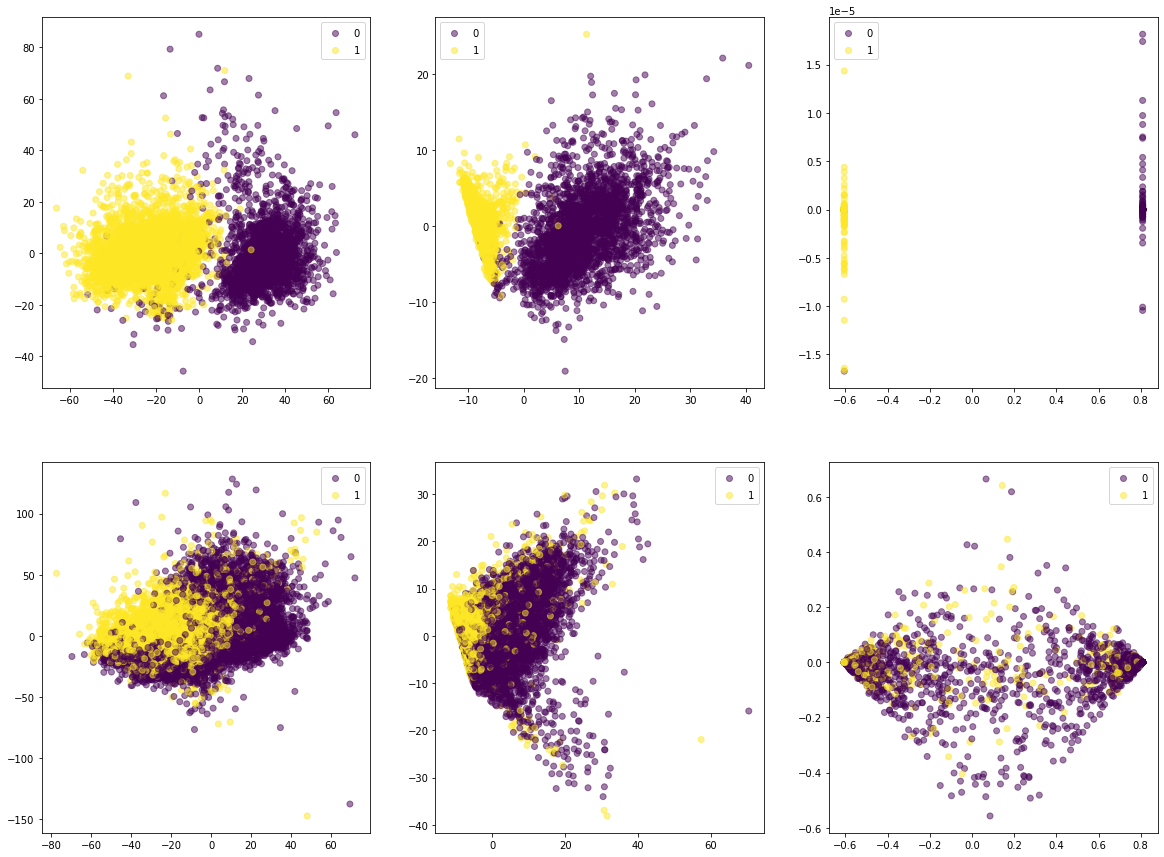

In [9]:
intermediate_pca_data, intermediate_pca_data_test = ut.get_pca(intermediates, data_test=intermediates_test)
fig, axs = plt.subplots(2, 3, figsize=(20,15))
ut.plot_representations(intermediate_pca_data, labels, axs[0, 0])
ut.plot_representations(intermediate_pca_data_test, labels_test, axs[1, 0])
intermediate2_pca_data, intermediate2_pca_data_test = ut.get_pca(intermediates2, data_test=intermediates2_test)
ut.plot_representations(intermediate2_pca_data, labels, axs[0, 1])
ut.plot_representations(intermediate2_pca_data_test, labels_test, axs[1, 1])
output_pca_data, output_pca_data_test = ut.get_pca(outputs, data_test=outputs_test)
ut.plot_representations(output_pca_data, labels, axs[0, 2])
ut.plot_representations(output_pca_data_test, labels_test, axs[1, 2])

first
first ..
first ...


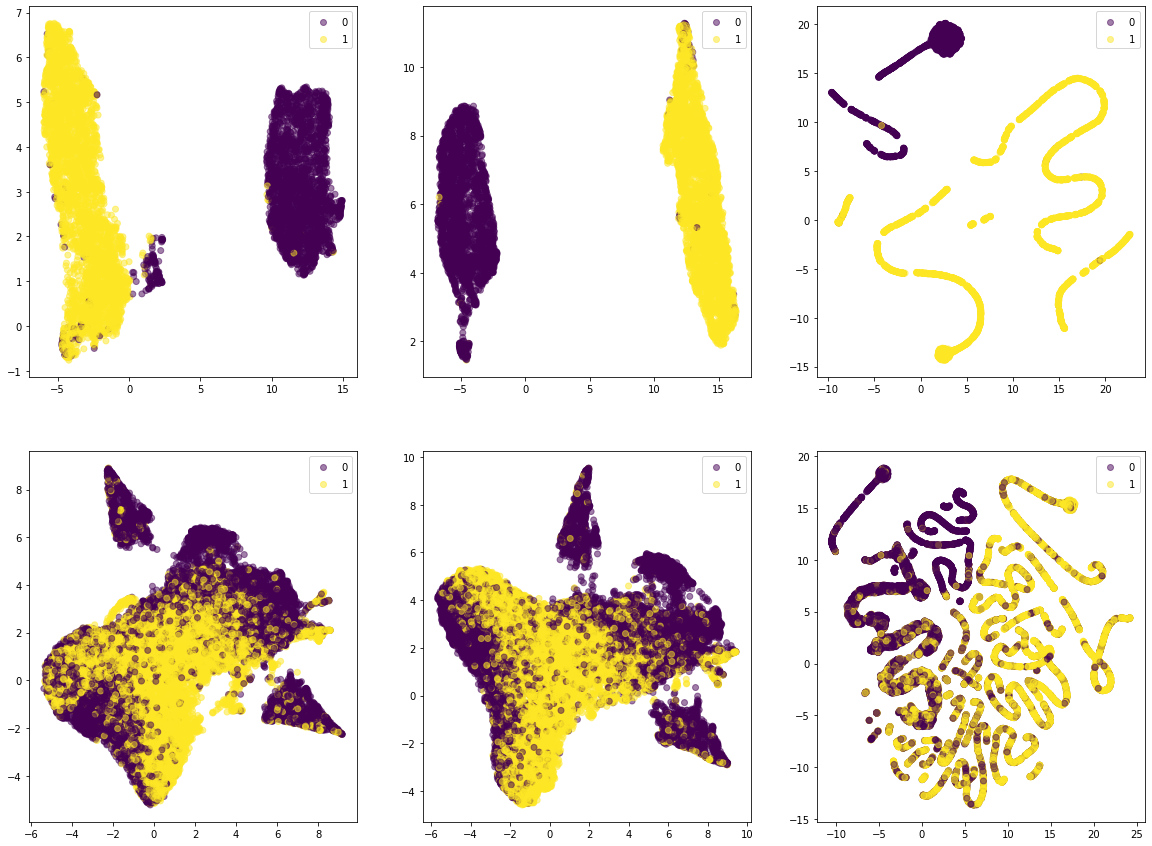

In [10]:
import umap

fig, axs = plt.subplots(2, 3, figsize=(20,15))
print('first')
reducer = umap.UMAP()
print('first ..')
mapper_train = reducer.fit_transform(intermediates.numpy())
print('first ...')
reducer = umap.UMAP()
mapper_test = reducer.fit_transform(intermediates_test.numpy())
ut.plot_representations(mapper_train, labels, axs[0, 0])
ut.plot_representations(mapper_test, labels_test, axs[1, 0])

reducer = umap.UMAP()
mapper_train = reducer.fit_transform(intermediates2.numpy())
reducer = umap.UMAP()
mapper_test = reducer.fit_transform(intermediates2_test.numpy())
ut.plot_representations(mapper_train, labels, axs[0, 1])
ut.plot_representations(mapper_test, labels_test, axs[1, 1])

reducer = umap.UMAP()
mapper_train = reducer.fit_transform(outputs.numpy())
reducer = umap.UMAP()
mapper_test = reducer.fit_transform(outputs_test.numpy())

ut.plot_representations(mapper_train, labels, axs[0, 2])
ut.plot_representations(mapper_test, labels_test, axs[1, 2])

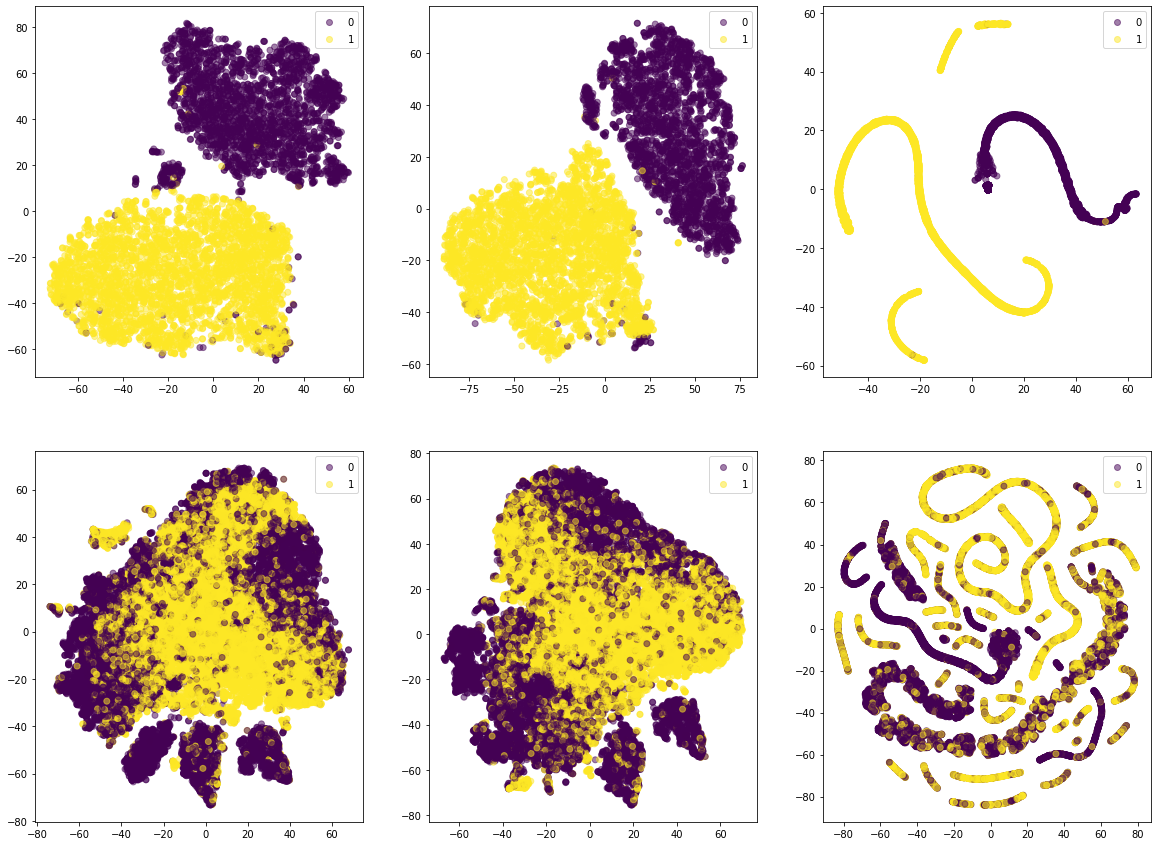

In [11]:
N_CURVES = 25000

fig, axs = plt.subplots(2, 3, figsize=(20,15))
intermediate_tsne_data, intermediate_tsne_data_test = ut.get_tsne(intermediates, data_test= intermediates_test, n_curves = N_CURVES)
ut.plot_representations(intermediate_tsne_data, labels, axs[0, 0],  n_curves = N_CURVES)
ut.plot_representations(intermediate_tsne_data_test, labels_test, axs[1, 0], n_curves = N_CURVES)

intermediate2_tsne_data, intermediate2_tsne_data_test = ut.get_tsne(intermediates2, data_test=intermediates2_test, n_curves = N_CURVES)
ut.plot_representations(intermediate2_tsne_data, labels, axs[0, 1], n_curves = N_CURVES)
ut.plot_representations(intermediate2_tsne_data_test, labels_test, axs[1, 1], n_curves = N_CURVES)

output_tsne_data, output2_tsne_data_test = ut.get_tsne(outputs, data_test=outputs_test, n_curves = N_CURVES)
ut.plot_representations(output_tsne_data, labels, axs[0, 2], n_curves = N_CURVES)
ut.plot_representations(output2_tsne_data_test, labels_test, axs[1, 2], n_curves = N_CURVES)

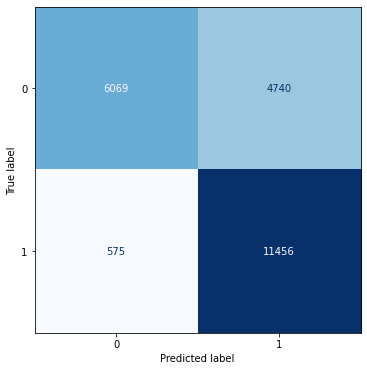

In [12]:
#fig, ax = plt.subplots(1, 1, figsize=(15,15))
#curves, labels, probs_train = ut.get_predictions(net, train_loader_pred, device)
#pred_labels = probs_train.argmax(1, keepdim = True)
#ut.plot_confusion_matrix(np.round(labels), pred_labels, ax)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
curves, labels, probs_test = ut.get_predictions(net, test_loader_pred, device)
pred_labels = probs_test.argmax(1, keepdim = True)
ut.plot_confusion_matrix(np.round(labels), pred_labels, ax)

In [13]:
curves, labels, probs_train_sample = ut.get_predictions(net, train_loader, device)

In [14]:
#N_WEIGHTS = 25
#weights = net.fc2.weight.data
#plot_weights(weights, N_WEIGHTS)

In [15]:
weights1 = net.fc1.weight.data
w1 = weights1.cpu().numpy().reshape(-1,1)
weights2 = net.fc2.weight.data
w2 = weights2.cpu().numpy().reshape(-1,1)
weights3 = net.fc3.weight.data
w3 = weights3.cpu().numpy().reshape(-1,1)

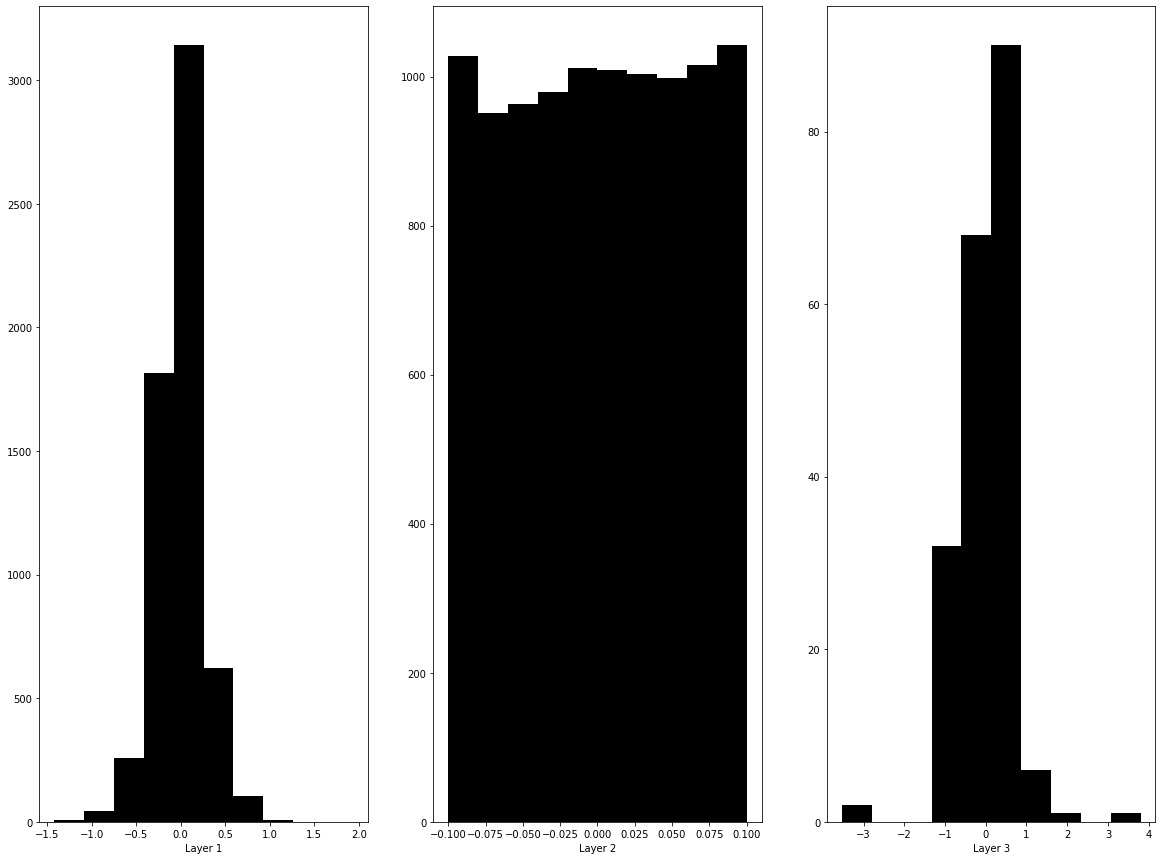

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,15))
ax1.hist(w1, color='black')
ax1.set_xlabel('Layer 1')
ax2.hist(w2, color='black')
ax2.set_xlabel('Layer 2')
ax3.hist(w3, color='black')
ax3.set_xlabel('Layer 3')
plt.show()

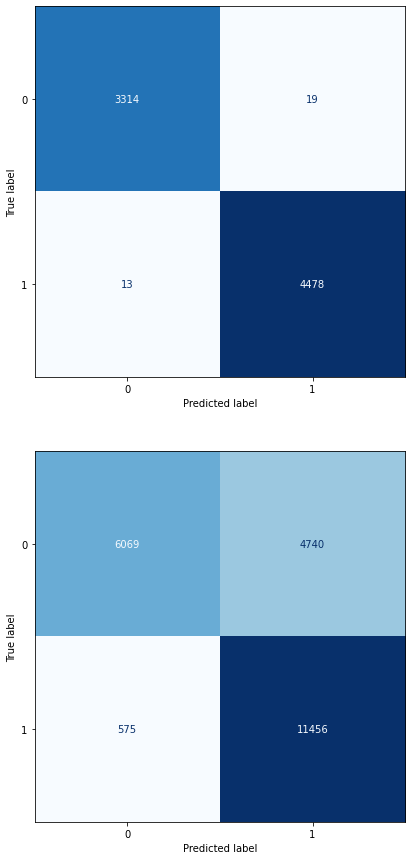

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))
curves, labels, probs_train = ut.get_predictions(net, train_loader_pred, device)
pred_labels = torch.argmax(probs_train, 1)
ut.plot_confusion_matrix(np.round(labels), pred_labels, ax1)
curves, labels, probs_test = ut.get_predictions(net, test_loader_pred, device)
pred_labels = torch.argmax(probs_test, 1)
ut.plot_confusion_matrix(np.round(labels), pred_labels, ax2)